In [1]:
# First let's import
# Let's do our imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import pandas_profiling
import seaborn as sns; sns.set()
import category_encoders as ce
import graphviz
from sklearn.tree import export_graphviz
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline

In [2]:
# Let's try out that new workflow from the random forests lecture
# Let's get our data
Location = "../data/tanzania/"

train = pd.merge(pd.read_csv(Location + 'train_features.csv'),
                 pd.read_csv(Location + 'train_labels.csv'))

test = pd.read_csv(Location + 'test_features.csv')
sample_submission = pd.read_csv(Location + 'sample_submission.csv')

# Now Let's do our test(val)-train split

train, val = train_test_split(train, train_size=0.80, test_size=0.20, random_state=42, 
                              stratify=train['status_group'])

# Next comes our feature engineering function
def organize(X):
    """Function will organize the features of train, validate and test sets in the same way"""
    X = X.copy()
    # Before we do any engineering we'll use what we've learned through pandas_profiler or general exploration to 
    # name some duplicate and meaningless features we will drop later
    duplicates = ['quantity_group', 'extraction_type_group', 'quality_group']
    meaningless = ['id', 'recorded_by', 'num_private']
    
    # We'll start our engineering with latitude and it's tiny values (3% of total)
    # First, we have to replace these values with 0
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # Now those values are the same as the incorrect null values in some of our other features
    colsw0s = ['longitude', 'latitude', 'population', 'gps_height', 'construction_year']
    
    # We'll turn those 0's into np.nan the replace them with the median of their columns
    # I don't like mean for situations like this, so I would almost always choose median or mode
    for col in colsw0s:
        X[col] = X[col].replace(0, np.nan)
#         X[col] = X[col].fillna(X[col].median())
    
    
    # Next we'll convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # And we'll extract year_recorded, month_recorded, and day_recorded also
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    # We'll also add date_recorded to meaningless since it adds nothing now
    meaningless = meaningless + ['date_recorded']
 
    
    # Next we'll work with the different source features
    # We're going to fuse the source_type and source_class features into source_cat
    X['source_cat'] = X['source_class'] +['_'] + X['source_type']
    # Now we set the tree source features to be dropped
    duplicates = duplicates + ['source', 'source_type', 'source_class']
    
#     # And we'll fill the missing values for categorical features with 'MISSING'
#     cats = X.select_dtypes(exclude='number').columns
#     for col in cats:
#         X[col] = X[col].fillna('MISSING')
    
    # Now we'll drop our meaningless and duplicate features
    todrop = duplicates + meaningless
    X = X.drop(columns=todrop)
        
    return X

train = organize(train)
val = organize(val)
test = organize(test)

In [3]:
train.sample(10)

,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,basin,subvillage,region,...,payment_type,water_quality,quantity,waterpoint_type,waterpoint_type_group,status_group,year_recorded,month_recorded,day_recorded,source_cat
12110,500.0,District Council,980.0,District Council,37.606720,-3.736011,Chanjare Primary School,Pangani,Chanjare,Kilimanjaro,...,per bucket,soft,insufficient,communal standpipe,communal standpipe,functional,2013,3,7,groundwater_spring
57221,50.0,0,7.0,0,39.187358,-6.902269,Kwa Mhagama,Wami / Ruvu,Mtaa Wa Kitunda Kati,Dar es Salaam,...,per bucket,soft,enough,communal standpipe,communal standpipe,functional,2013,3,21,groundwater_borehole
4678,0.0,Rwssp,NaN,WEDECO,34.235974,-3.026004,Maji Bora,Lake Victoria,Bukingwa,Shinyanga,...,never pay,soft,enough,hand pump,hand pump,functional,2012,11,15,groundwater_shallow well
7559,0.0,Denish,547.0,DENISH,37.655271,-6.692594,Kwa Mzee Meza,Wami / Ruvu,Cct,Morogoro,...,never pay,soft,enough,hand pump,hand pump,non functional,2011,8,3,groundwater_shallow well
31788,1000.0,Dhv,315.0,DWE,36.349827,-8.799884,Kwa Msangura,Rufiji,Cuba,Morogoro,...,monthly,soft,enough,communal standpipe,communal standpipe,functional,2011,3,20,surface_river/lake
36165,50.0,Ministry Of Water,1407.0,NYAKILANGANI CO,34.018292,-1.903308,Kwa Makongoro,Lake Victoria,Msirigani,Mara,...,per bucket,soft,enough,communal standpipe multiple,communal standpipe,non functional,2012,11,2,groundwater_borehole
39436,10.0,Germany Republi,1161.0,CES,37.173867,-3.271479,Area 17 Namba 45,Pangani,Isawero,Kilimanjaro,...,per bucket,soft,enough,communal standpipe,communal standpipe,functional,2013,1,3,groundwater_spring
54001,50.0,Ruthe,1423.0,Ruthe,35.627927,-7.686965,none,Rufiji,Mlangali,Iringa,...,per bucket,soft,dry,communal standpipe,communal standpipe,non functional,2011,3,7,groundwater_spring
30274,0.0,Amref,-10.0,AMREF,39.329425,-7.320069,Kibewa,Wami / Ruvu,Kibewa,Pwani,...,never pay,soft,insufficient,hand pump,hand pump,functional,2011,3,23,groundwater_shallow well
58519,20.0,Tasaf,80.0,DWE,38.661147,-5.805921,Kwamkungamani,Pangani,Kwamkungamani,Tanga,...,per bucket,salty,insufficient,communal standpipe,communal standpipe,non functional,2011,3,17,groundwater_borehole


In [4]:
# Now we can work with our features
# We'll set the target first
target = 'status_group'

# Now we'll set a df with all train features except for our target and the id column
trainfeat = train.drop(columns=[target])

# We'll also separate the numeric features into one list...
numfeat = trainfeat.select_dtypes(include='number').columns.tolist()

# And we'll get the cardinality of the non-numeric features...
cardinality = trainfeat.select_dtypes(exclude='number').nunique()

# And then we'll get the list for categorical features with cardinality <= 50
catfeat = cardinality[cardinality <= 50].index.tolist()

# Finally we'll combine those lists
feats = numfeat + catfeat

In [5]:
# Now let's take a look at cardinality
cardinality.sort_values()

permit                       2
public_meeting               2
quantity                     5
management_group             5
waterpoint_type_group        6
waterpoint_type              7
payment_type                 7
payment                      7
extraction_type_class        7
source_cat                   7
water_quality                8
basin                        9
management                  12
scheme_management           12
extraction_type             18
region                      21
lga                        124
funder                    1716
installer                 1929
ward                      2082
scheme_name               2563
subvillage               17231
wpt_name                 30661
dtype: int64

In [6]:
# and also catfeat
catfeat

['basin',
 'region',
 'public_meeting',
 'scheme_management',
 'permit',
 'extraction_type',
 'extraction_type_class',
 'management',
 'management_group',
 'payment',
 'payment_type',
 'water_quality',
 'quantity',
 'waterpoint_type',
 'waterpoint_type_group',
 'source_cat']

In [7]:
# and finally feats
feats

['amount_tsh',
 'gps_height',
 'longitude',
 'latitude',
 'region_code',
 'district_code',
 'population',
 'construction_year',
 'year_recorded',
 'month_recorded',
 'day_recorded',
 'basin',
 'region',
 'public_meeting',
 'scheme_management',
 'permit',
 'extraction_type',
 'extraction_type_class',
 'management',
 'management_group',
 'payment',
 'payment_type',
 'water_quality',
 'quantity',
 'waterpoint_type',
 'waterpoint_type_group',
 'source_cat']

In [8]:
len(feats)

27

In [9]:
# Now let's use our new tools: Pipeline, OrdinalEncoder, SimpleImputer
# First we arrange our data into X features matrix and y target vector
xtrain = train[feats]
ytrain = train[target]

xval = val[feats]
yval = val[target]

xtest = test[feats]

# Now let's setup our pipeline
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    DecisionTreeClassifier(max_depth=10, random_state=42)
)

# Fit on train, score on val, predict on test
pipeline.fit(xtrain, ytrain)
print('Val Acc:', pipeline.score(xval, yval))

Val Acc: 0.7484006734006734


In [37]:
# Now let's try our RandomForestClassifier

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(max_depth=20 ,n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on val, predict on test
pipeline.fit(xtrain, ytrain)
print('Train Acc:', pipeline.score(xtrain, ytrain))
print('Val Acc:', pipeline.score(xval, yval))
ypred = pipeline.predict(xtest)

# # Let's write our submission csv file
# submission = sample_submission.copy()
# submission['status_group'] = ypred
# submission.to_csv('rfsubmission.csv', index=False)

Train Acc: 0.9575126262626262
Val Acc: 0.812037037037037


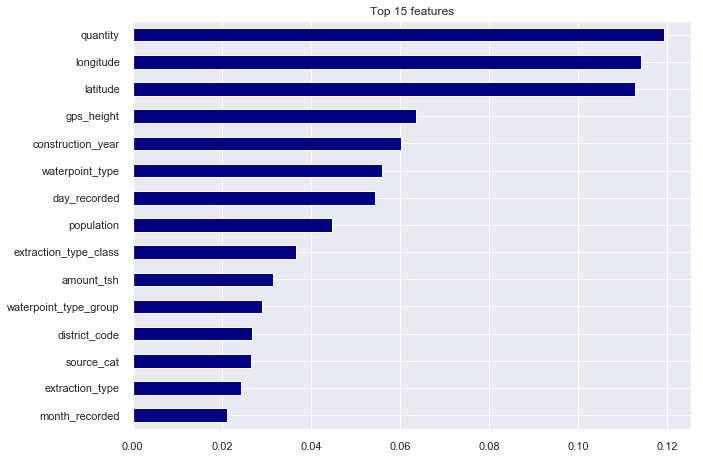

In [38]:
# That's probably going to be our highest score
# Let's explore the pipeline and model

# First let's get the feature importances
encoder  = pipeline.named_steps['ordinalencoder']
forest = pipeline.named_steps['randomforestclassifier']

featnames = encoder.transform(xval).columns
importances = pd.Series(forest.feature_importances_, featnames)

# And let's plot the top 15
n = 15
plt.figure(figsize=(10, n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='navy');

In [40]:
# Now let's take a look at one of the trees from our forest

dot_data = export_graphviz(forest, 
                           out_file=None, 
                           max_depth=4, 
                           feature_names=featnames, 
                           class_names=forest.classes_, )
                           impurity=False, 
                           filled=True, 
                           proportion=True,
                           rotate=True, 
                           rounded=True)

graphviz.Source(dot_data)

NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.